In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
# import rioxarray as rxr
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import intake
import s3fs
import cartopy.crs as ccrs
import cartopy.feature as cfeature

india_boundary = gpd.read_file('India_ADM0_simplified.simplified.geojson')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/eds296-stevenson/share/proj failed


In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

In [3]:
# define date ranges
tr_begin = 1900
tr_end = 2100

map_tr_hist_begin = 1900
map_tr_hist_end = 1950

map_tr_sim_begin = 2050
map_tr_sim_end = 2100

# India bbox
lat_min, lat_max = india_boundary.bounds["miny"][0], india_boundary.bounds["maxy"][0]
lon_min, lon_max = india_boundary.bounds["minx"][0], india_boundary.bounds["maxx"][0]

# query vars
# activity_id = specify project in which simulations fall under
activity_ids = ['ScenarioMIP', 'CMIP'] # future projections and historical

# select NOAA for climate and earth system models (GFDL)
models = 'MPI-ESM1-2-HR'

# experimental_ids = scenarios (or historical)
scenarios = ['historical', 'ssp585']

# member_id = ensemble member the set of programmed conditions that affect the behavior of the model. We can program a model with different environmental factors, even different physics just to see what happens.
conditions = 'r1i1p1f1'

# table_id = specify spatial and temporal window & resolution
spatial_temporal = 'Amon' # Monthly atmospheric data

# variable_id = climatic variable
variable = [
    'pr', # precipitation (kg m-2 s-1)
    'sfcWind' # near surface wind speed (m s-1)
] 

In [4]:
# Convert the catalog to a Pandas datazrame
cat_df = catalog.df

# Search through catalog, find all historical simulations
res = catalog.search(
    activity_id=activity_ids, 
    variable_id = variable, 
    table_id = spatial_temporal, 
    source_id = models, 
    member_id = conditions,
    experiment_id = scenarios
)

# Convert to a data frame
res_df = res.df
res_df



,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,Amon,sfcWind,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710
1,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710
2,ScenarioMIP,DKRZ,MPI-ESM1-2-HR,ssp585,r1i1p1f1,Amon,sfcWind,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/DKRZ/MPI-ESM1...,NaN,20190710
3,ScenarioMIP,DKRZ,MPI-ESM1-2-HR,ssp585,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/DKRZ/MPI-ESM1...,NaN,20190710


In [5]:
def zarr_prepare(response_df, variable, scenario, start_year, end_year, agg_by, bbox, mask = True):
    
    # historical
    hist = xr.open_zarr(
        response_df[
            (response_df["experiment_id"] == "historical") & 
            (response_df["variable_id"] == str(variable))
        ]["zstore"].iloc[0], # imput historical data code
        storage_options = {'anon':True}
    ).convert_calendar("standard")

    # future projections
    sim = xr.open_zarr(
        response_df[
            (response_df["experiment_id"] == str(scenario)) & 
            (response_df["variable_id"] == str(variable))
        ]["zstore"].iloc[0], # input simulation data code
        storage_options = {'anon':True}
    ).convert_calendar("standard")

    concat = xr.concat([hist, sim], dim = "time") # attach the two
    
    
    sliced = concat.sel(
        time = slice(f"{start_year}-01-01", f"{end_year}-12-31" # specify the time range
        )
    )
    
    # init bounds
    if mask == True:
        lat_min, lat_max = bbox[0], bbox[1]
        lon_min, lon_max = bbox[2], bbox[3]
        
        masked = sliced.sel(lat = slice(lat_min, lat_max), 
                        lon = slice(lon_min, lon_max))
    
    
    # convert sr mm/second to mm/day
    converted = sliced * (60*60*24)
    
    # spatial average
    averaged = converted.mean(dim=agg_by)
    
    return averaged

In [6]:
def get_trendline(df, variable, hist_tr, bbox):
    
    model_hist = df[variable].sel(time = slice(*hist_tr))
    model_full = df[variable]
    
    # then consolidate those means to get a yearly average
    model_hist_yrly = model_hist.groupby('time.year').mean() 
    model_full_yrly = model_full.groupby('time.year').mean() 
    
    
    # fit the line
    x_hist = np.polyfit(model_hist_yrly.year, model_hist_yrly, 1) 
    x_full = np.polyfit(model_full_yrly.year, model_full_yrly, 1)
    # then generate the object
    trend_line_hist = np.poly1d(x_hist)
    trend_line = np.poly1d(x_full)
    
    # return all vars needed for the graph
    return trend_line, trend_line_hist, model_full_yrly, model_hist_yrly, x_full, x_hist
    

In [7]:
def visualize_model(model_trendlines, hist_trendline, model_means, hist_mean, model_slopes, hist_slope, title):
    
    # make iterable vars
    var_name = ['Precipitation', "Wind Speed"]
    units = ['kg m\u207B\u00B2 s\u207B\u00B9', 'm s\u207B\u00B9']
    scenario_list = ['historical', '585'] # scenario number for legend labeling
    color_list1 = ['midnightblue', 'peru'] # historical projection colors
    color_list2 = ['dodgerblue', 'crimson'] # future scenario colors
    

    
    # generate the graph
    fig, axes = plt.subplots(figsize=(12,5 * len(model_means)), nrows = len(model_means), sharex = True)
    
    fig.suptitle(title, y = 0.93, fontsize = 15)
        
    for i, ax in enumerate(axes):
        
        # raw, non regressed soil moisture lines, both predicted and historical
        ax.plot(
            model_means[i].year, # x = year
            model_means[i], # y = variable, hist than sim
            label= f'Historical with Projections', 
            color = color_list1[i], # iterate for colors midnight blue, peru
            alpha = 0.5 # allow both lines to show through each other
        )

        # plot trendlines

        # historical
        ax.plot(
            hist_mean[i].year, # x = year
            hist_trendline[i](hist_mean[i].year), # y = soil moisture 
            color='teal', 
            linestyle='-', 
            linewidth = 4, 
            label=f'{var_name[i]} Historical Trend Line (Slope = {hist_slope[i][0]:.4f})'

        )

        # future scenario
        ax.plot(
            model_means[i].year, # x = year
            model_trendlines[i](model_means[i].year), # y = soil moisture 
            color=color_list2[i], # iterate for colors dodger blue, crimson
            linestyle='--',  # set linestyle distinct from historical trendline
            linewidth = 3, 
            label=f'{var_name[i]} Future Scenario Trend Line (Slope = {model_slopes[i][0]:.4f})'
        )
        
        ax.legend() # init legend
        ax.set_xlabel('Year')
        ax.set_ylabel(f'{var_name[i]} ({units[i]})')


    plt.show()
    


In [8]:
full_bbox = [lat_min, lat_max, lon_min, lon_max]

precip_zarr = zarr_prepare(response_df = res_df, 
                           variable = variable[0],
                           scenario = scenarios[1], 
                           start_year = tr_begin, 
                           end_year = tr_end, 
                           agg_by = ['lat', 'lon'], 
                           bbox = full_bbox)

wind_zarr = zarr_prepare(response_df = res_df, 
                         variable = variable[1],
                         scenario = scenarios[1], 
                         start_year = tr_begin, 
                         end_year = tr_end, 
                         agg_by = ['lat', 'lon'], 
                         bbox = full_bbox)

In [9]:
# create plotting variables
full_bbox = [lat_min, lat_max, lon_min, lon_max]
curr_zarr1 = precip_zarr
curr_zarr2 = wind_zarr
hist_tr = [np.min(wind_zarr.time).values.astype(str)[:4], '1950']

sim_trend_precip, hist_trend_precip, sim_mean_precip, hist_mean_precip, sim_slope_precip, hist_slope_precip = get_trendline(curr_zarr1, variable[0], hist_tr, full_bbox)
sim_trend_wind, hist_trend_wind, sim_mean_wind, hist_mean_wind, sim_slope_wind, hist_slope_wind = get_trendline(curr_zarr2, variable[1], hist_tr, full_bbox)

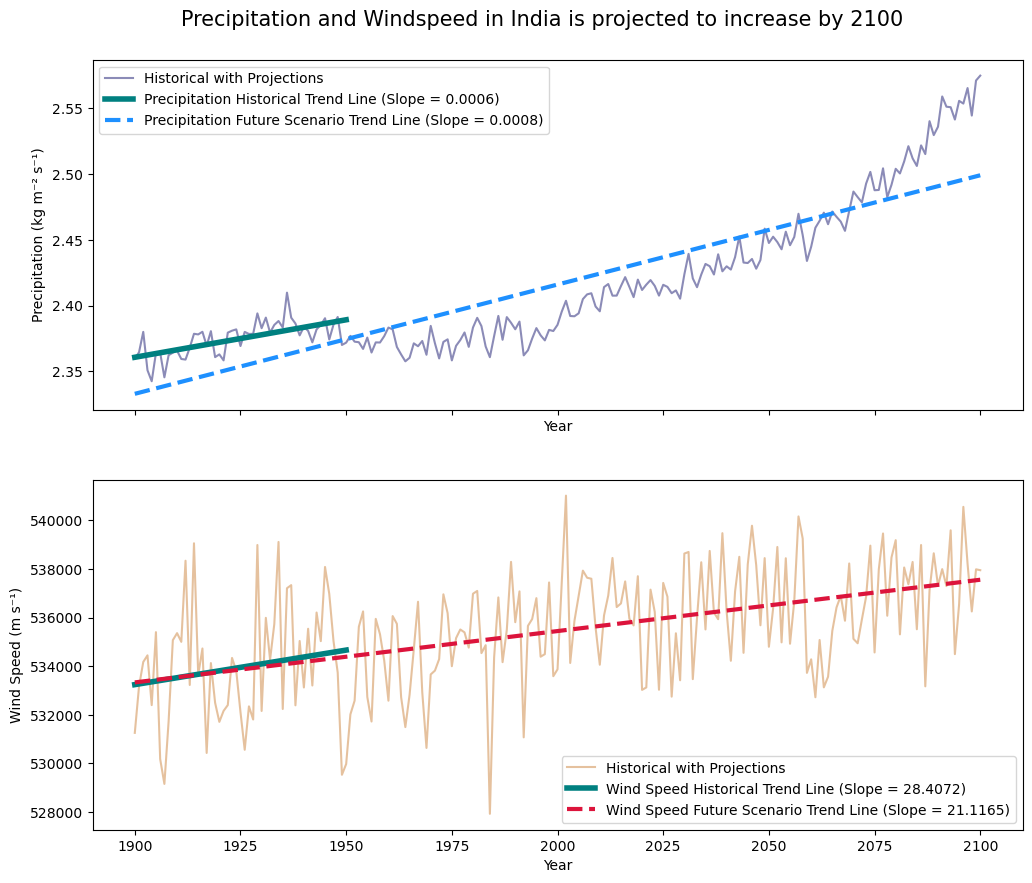

In [10]:
visualize_model(
    [sim_trend_precip, sim_trend_wind], # predicting trendlines
    [hist_trend_precip, hist_trend_wind], # historical trendline
    [sim_mean_precip, sim_mean_wind], # predicting yearly averages for soil moisture
    [hist_mean_precip, hist_mean_wind], # historical yearly average
    [sim_slope_precip, sim_slope_wind], # predictive coefs from linear regression (slope and y int, but we only use slope)
    [hist_slope_precip, hist_slope_wind], # historical lin reg coeffs
    'Precipitation and Windspeed in India is projected to increase by 2100' # title of graph
)